# Navigation

This assignment aims at training an agent that navigates a square world in the Unity framework, collecting yellow bananas while avoiding blue bananas. Training will happen using a reinforcement learning technique that uses deep learning to learn agent policies.

## The Problem

In this simulation, the agent's task is to search for yellow bananas while avoiding blue bananas. As such, the environment will return rewards of `1` for a yellow banana, `-1` for a blue banana and `0` otherwise.

Here's how the simulation looks like:

![banana](banana-example.png)

### State Space

The state space for the banana environment has `37` dimensions in total. These are `floats` representing speed and a representations of what is in the agent's line of sight. (Further details on the state description can be found in [2]).

One example of a state space retrieved from the banana environment as a `numpy` array:

```
[ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
```


### Action Space

At each time step, it has `4` actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right


## Solution

The solution uses Deep Queue Networks, as discussed on [1], deep learning can be used as a mechanism for approximating optimal policies for a RL agent.

In particular, the paper discusses the following improvements that helped stabilize learning:
* **Experience Replay** - Randomly sampling from a cache of recent experiences to break correlation on the sequence of observations.
* Use of two networks (target and online), where the online network is updated periodically with weights from the learned off-policy network.

### Network

The DQN network is a 2-layer dense network with `64` units in each layer, using **ReLU** as the activation function.

### Hyper Parameters
We started the experiment using hyper parameters recommended in [1], and the default implementation of the Udacity _Lunar Lander_ lesson. In this notebook we also performed experimentation on some of the crucial hyper parameters related to the DQN paper, namely: replay memory size, and the update frequency. We also experimented with the value of `TAU` (factor for the weight soft-update).

Our final hyper parameters are shown below:

  | Parameter.                          | Value | Origin |
  | ----------------------------------- | ----- | -------|
  | Replay buffer size                  | 25000 | Experimentation |
  | Learning rate                       | 0.00025  | DQN paper [1] |
  | Update interval                     | 4     | Lunar Lander defaults |
  | Mini batch size                     | 64    | DQN paper [1] |
  | $\gamma$ (discount factor)          | 0.99  | DQN paper [1] |
  | $\tau$ (soft update factor)         | 0.01  | Experimentation |
  | Number of episodes                  | 1000   | Experimentation |
  | Max steps per episode               | 500  | Experimentation |
  | Initial $\epsilon$                  | 1.0   | DQN paper [1] |
  | Lower $\epsilon$                    | 0.1   | DQN paper [1] |
  | $\epsilon$ decay                    | 0.995 | Lunar Lander defaults |

## Results

![scores](agent-trend-final.png)


## Setup

### Pre Requisites
**Instructions for Local Run**
(should be already met when run from a Udacity env)

* `pip install unityagents`
* Download the Banana unity app from: https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/Banana.app.zip
* Unzip into local directory where notebook is.

### Project Files

This repo contains the following files under the `p1_navigation` directory:

```
P1_Navigation.ipynb    - notebook containing the entire code of the assignment.
banana_final_model.bin - model weights

README.md              - this file.
agent-trend-final.png  - supporting chart
banana-example.png     - supporting image
replay_sizes.csv       - scores for replay size experiment
replay_tau.csv         - scores for tau experiment
replay_update_freq.csv - scores for update frequency experiment
```

### Running the Project

* `git clone` this repository.
* download the Banana Unity app into the same directory as the jupyter notebook (`<ROOT>/p1_navigation`) (https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/Banana.app.zip)
* run the jupyter notebook.

## References

[1] - "Human-level control through deep reinforcement learning" - Mnih et al, Feb/2015 (Nature) - https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf

[2] - Note on state description:  https://github.com/Unity-Technologies/ml-agents/issues/1134


---


# Assignment

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

The next cell will Load the Banana app downloaded in the same location as this Jupyter notebook.

```
env = UnityEnvironment(file_name="Banana.app")
```

We will also get the _brain_ (Unity's environment controller) which will be used later in training.

In [2]:
env = UnityEnvironment(file_name='Banana.app')


brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 2. Examine the State and Action Spaces



In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)

state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Build a Neural Net

Lets build a deep Neural Net to approximate our agent's `Q*` function. The implementation is as follows:

* Two dense layers and an output layer. Each dense layer has `64` units.
* `ReLU` activation.
* Output squashed with a Sigmoid function.


The code below builds the `DQN` class using `PyTorch`.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class DQN(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        super(DQN, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### 4. The Replay Buffer

The Replay buffer implementation is based on the materials provided in the Udacity Nanodegree for the _Lunar Lander_ exercise (https://github.com/udacity/deep-reinforcement-learning/tree/master/dqn/solution). No significant changes have been made to the original implementation. 

In [5]:
from collections import deque, namedtuple
import random


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size  # TODO: nort really used anywhere
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### 5. Build the Unity Agent

In [6]:
import torch.nn.functional as F
import torch.optim as optim


class UnityAgent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed, debug=False):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.debug = debug

        # Q-Network
        self.qnetwork_local = DQN(state_size, action_size, seed).to(device)
        self.qnetwork_target = DQN(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    
    def log(self, msg):
        if self.debug:
            print(msg)
    
    def step(self, state, action, reward, next_state, done):
        '''Move forward the DQN by one episode step
        
           - Update replay buffer
           - optionally run backprop on the DQN (every UPDATE_EVERY), with a batch BATCH_SIZE
        '''
        
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        
        if self.t_step == 0:
            
            # If enough samples are available in memory, get random subset from replay and run DQN learn
            if len(self.memory) > BATCH_SIZE:
                # sample BATCH_SIZE experiences from trhe replay buffer
                experiences = self.memory.sample()
                
                # backprop
                self.log('Selected {} experientces to learn DQN'.format(len(experiences)))
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """
        
           Returns actions for given state as per current e-greedy policyp.
        
           This step performas inference on the DQN, so we disable backprop and inform torch layers
           that we are in "eval" mode.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        
        # model.eval() will notify all your layers that you are in eval mode
        # that way, batchnorm or dropout layers will work in eval model instead of training mode.
        self.qnetwork_local.eval()
        
        # disable backprop
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        
        # switch back to "train" mode
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """
        
           Implement DQN learning step via back prop.
           
        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        
        # Compute Q targets for current states
        # This computes the optimization step where we aproximate Q* as:
        # Q*(s, a) ~ R + gamma * max(Q*(s', a'))
        #
        # - Note: (1 - dones) -> do not count ststes where the episode has finished
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        self.log('... Q_targets: {}'.format(Q_targets))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        
        self.log('... Q_expected: {}'.format(Q_expected))

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        
        # Minimize the loss
        self.optimizer.zero_grad()
        
        loss.backward()
        self.optimizer.step()

        # soft-update the target network with local  parameters
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0 - tau)*target_param.data)

Here we define a helper function to extract a `(state, reward, done)` tuple from the unity env.

In [7]:
def get_unity_tuple(info):
    '''Given an info obj from unity, retrieves tuple (state, reward, done) where:
      - state:  np.array of current states.
      - reward: float, the reward given after step
      - done:   bool, is episode done
    '''
    reward = info.rewards[0]
    state = info.vector_observations
    done = info.local_done[0]
    
    return state, reward, done

### 5. DQN Learn Alrogithm

In [8]:
def dqn_learn(agent, env, brain, n_episodes=10000, max_t=1000,
              eps_start=1.0, eps_end=0.01, eps_decay=0.995, save=False):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        
    scores_window = deque(maxlen=50)   
    eps = eps_start                    
    
    for i_episode in range(1, n_episodes+1):
        state, _, _ = get_unity_tuple(env.reset(train_mode=True)[brain])
        score = 0
        t = 0

        while t < max_t:
            action = agent.act(state, eps)
            next_state, reward, done = get_unity_tuple(env.step(action)[brain])
            
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            
            if done:
                break
            
            t += 1
            
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decay epsilon
        
        print('\rEpisode {}\tAverage Score (last 50): {:.3f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 50 == 0:
            print('\rEpisode {}\tAverage Score (last 50): {:.3f}; eps now: {:.3f}'.format(i_episode,
                                                                                np.mean(scores_window),
                                                                                eps))
            
    if save:
        print('Saving model')
        torch.save(agent.qnetwork_local.state_dict(), 'banana_model.bin')
            
    return scores

### 6. Hyper Parameters

There are a number of hyper parameters we need to pay attention to, and systematically testing all of them (via something like grid search) would be too time consuming. Fortunately the DQN paper [1] (page 10) provides good starting points for a number of them, which we will use here as our starting points:

* Mini-batch size: `32`
* Discount factor (gamma): `0.99`
* Gradient descent update frequency: `4`
* Initial $\epsilon$ in policy: `1.0`
* Final $\epsilon$ in policy: `0.1` (maximum decay)

The original DQN paper does not use the weight soft-update mechanism, so we will use the default value provided on the _Lunar Lander_ exercise of `0.001`.

We define these parameters below:

In [9]:
BATCH_SIZE = 64       # minibatch size - draw this many episodes from memory
GAMMA = 0.99          # discount factor
TAU = 0.001           # for soft update of target parameters
LR = 0.00025          # learning rate 
UPDATE_EVERY = 4      # how often to update the network (in steps)
EPS_DECAY = 0.995
EPS_END = 0.01

For now, we will arbitrarily fix the number of episodes, steps and memory buffer as seen below:

In [10]:
BUFFER_SIZE = 5000
N_EPISODES = 300
MAX_T = 500

In [11]:
agent = UnityAgent(state_size=37,
                   action_size=4,
                   seed=0, debug=False)


scores = dqn_learn(agent, env, brain_name,
                   n_episodes=N_EPISODES,
                   max_t=MAX_T,
                   eps_decay=EPS_DECAY,
                   eps_end=EPS_END)


np.mean(scores)

Episode 50	Average Score (last 50): 0.380; eps now: 0.778
Episode 100	Average Score (last 50): 1.060; eps now: 0.606
Episode 150	Average Score (last 50): 2.820; eps now: 0.471
Episode 200	Average Score (last 50): 5.580; eps now: 0.367
Episode 250	Average Score (last 50): 6.180; eps now: 0.286
Episode 300	Average Score (last 50): 8.780; eps now: 0.222


4.1333333333333337

Great! The model is learning. Here's the trend of agent scores over epochs tested:

In [68]:
%matplotlib inline
import pandas as pd

def plot_scores(scores, smooth=False):
    sz = (15, 7)
    if smooth:
        ax = pd.Series(scores).rolling(window=50).mean().plot(figsize=sz)
    else:
        ax = pd.Series(scores).plot(figsize=sz)
    
    return ax


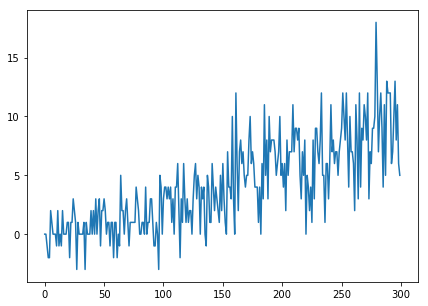

In [21]:
import matplotlib.pyplot as plt

plot_scores(scores)
plt.show()

#### 6.1 The effects of Replay SIze

For a given (fixed) number of steps, how does replay size affect learning?

In [22]:
scores_memtest = {}

for sz in [MAX_T, MAX_T*10, MAX_T*50]:
    BUFFER_SIZE = sz
    
    agent = UnityAgent(state_size=37, action_size=4, seed=0, debug=False)

    s = dqn_learn(agent, env, brain_name, n_episodes=N_EPISODES,
                  max_t=MAX_T, eps_decay=EPS_DECAY, eps_end=EPS_END)
    
    scores_memtest[sz] = s

Episode 50	Average Score (last 50): 0.060; eps now: 0.778
Episode 100	Average Score (last 50): 1.000; eps now: 0.606
Episode 150	Average Score (last 50): 2.940; eps now: 0.471
Episode 200	Average Score (last 50): 4.300; eps now: 0.367
Episode 250	Average Score (last 50): 6.780; eps now: 0.286
Episode 300	Average Score (last 50): 6.980; eps now: 0.222
Episode 50	Average Score (last 50): 0.260; eps now: 0.778
Episode 100	Average Score (last 50): 1.840; eps now: 0.606
Episode 150	Average Score (last 50): 3.460; eps now: 0.471
Episode 200	Average Score (last 50): 4.780; eps now: 0.367
Episode 250	Average Score (last 50): 6.440; eps now: 0.286
Episode 300	Average Score (last 50): 8.120; eps now: 0.222
Episode 50	Average Score (last 50): 0.140; eps now: 0.778
Episode 100	Average Score (last 50): 1.580; eps now: 0.606
Episode 150	Average Score (last 50): 2.380; eps now: 0.471
Episode 200	Average Score (last 50): 4.580; eps now: 0.367
Episode 250	Average Score (last 50): 6.860; eps now: 0.286


In [52]:
import pandas as pd

dfm = pd.DataFrame(scores_memtest)
dfm.to_csv('replay_sizes.csv')
dfm.mean()

500      3.676667
5000     4.150000
25000    4.070000
dtype: float64

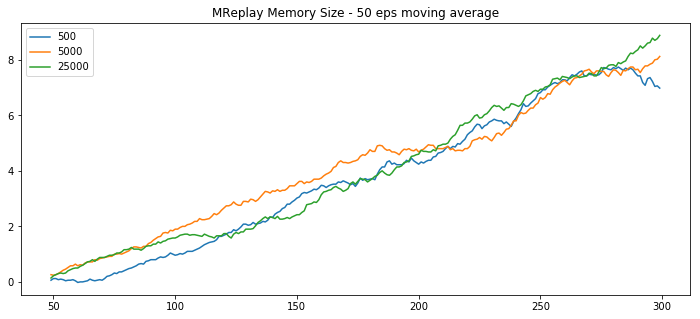

In [58]:
rolling_win = 50

dfm_smooth = pd.DataFrame([dfm[c].rolling(window=rolling_win).mean() for c in dfm.columns]).T
dfm_smooth.plot(title='MReplay Memory Size - {} eps moving average'.format(rolling_win), figsize=(12, 5))

#### 6.2 Varying Tau

In [53]:
BUFFER_SIZE=25000

scores_tau = {}


for sz in [1.0, 0.1, 0.01, 0.001]:
    TAU = sz
    
    agent = UnityAgent(state_size=37, action_size=4, seed=0, debug=False)

    s = dqn_learn(agent, env, brain_name, n_episodes=N_EPISODES,
                  max_t=MAX_T, eps_decay=EPS_DECAY, eps_end=EPS_END)
    
    scores_tau[sz] = s

Episode 50	Average Score (last 50): 0.020; eps now: 0.778
Episode 100	Average Score (last 50): -0.300; eps now: 0.606
Episode 150	Average Score (last 50): -0.340; eps now: 0.471
Episode 200	Average Score (last 50): -0.060; eps now: 0.367
Episode 250	Average Score (last 50): 1.460; eps now: 0.286
Episode 300	Average Score (last 50): 4.320; eps now: 0.222
Episode 50	Average Score (last 50): -0.100; eps now: 0.778
Episode 100	Average Score (last 50): 0.560; eps now: 0.606
Episode 150	Average Score (last 50): 1.580; eps now: 0.471
Episode 200	Average Score (last 50): 3.940; eps now: 0.367
Episode 250	Average Score (last 50): 6.780; eps now: 0.286
Episode 300	Average Score (last 50): 7.540; eps now: 0.222
Episode 50	Average Score (last 50): 0.820; eps now: 0.778
Episode 100	Average Score (last 50): 2.760; eps now: 0.606
Episode 150	Average Score (last 50): 3.480; eps now: 0.471
Episode 200	Average Score (last 50): 5.440; eps now: 0.367
Episode 250	Average Score (last 50): 7.240; eps now: 0.

In [54]:
dft = pd.DataFrame(scores_tau)
dft.to_csv('replay_tau.csv')
dft.mean()

0.001    4.150000
0.010    4.680000
0.100    3.383333
1.000    0.850000
dtype: float64

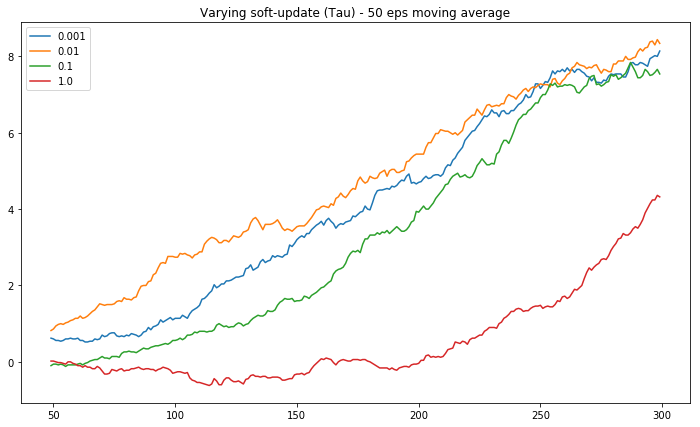

In [57]:
rolling_win = 50


dft_smooth = pd.DataFrame([dft[c].rolling(window=rolling_win).mean() for c in dft.columns]).T
dft_smooth.plot(title='Varying soft-update (Tau) - {} eps moving average'.format(rolling_win), figsize=(12, 7))

#### 6.3 Updating the target network

In [59]:
BUFFER_SIZE=25000
TAU=0.01

scores_upd = {}
for sz in [1, 4, 16, 64]:
    UPDATE_EVERY = sz
    
    agent = UnityAgent(state_size=37, action_size=4, seed=0, debug=False)

    s = dqn_learn(agent, env, brain_name, n_episodes=N_EPISODES,
                  max_t=MAX_T, eps_decay=EPS_DECAY, eps_end=EPS_END)
    
    scores_upd[sz] = s

Episode 50	Average Score (last 50): 0.560; eps now: 0.778
Episode 100	Average Score (last 50): 1.100; eps now: 0.606
Episode 150	Average Score (last 50): 1.820; eps now: 0.471
Episode 200	Average Score (last 50): 2.900; eps now: 0.367
Episode 250	Average Score (last 50): 5.420; eps now: 0.286
Episode 300	Average Score (last 50): 6.020; eps now: 0.222
Episode 50	Average Score (last 50): 0.240; eps now: 0.778
Episode 100	Average Score (last 50): 1.760; eps now: 0.606
Episode 150	Average Score (last 50): 3.680; eps now: 0.471
Episode 200	Average Score (last 50): 5.300; eps now: 0.367
Episode 250	Average Score (last 50): 6.100; eps now: 0.286
Episode 300	Average Score (last 50): 9.100; eps now: 0.222
Episode 50	Average Score (last 50): 0.300; eps now: 0.778
Episode 100	Average Score (last 50): 2.100; eps now: 0.606
Episode 150	Average Score (last 50): 3.960; eps now: 0.471
Episode 200	Average Score (last 50): 5.900; eps now: 0.367
Episode 250	Average Score (last 50): 5.640; eps now: 0.286


1     2.970000
4     4.363333
16    4.356667
64    2.593333
dtype: float64

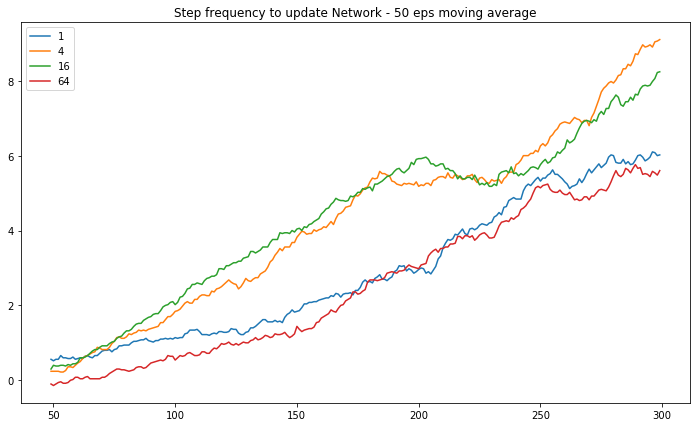

In [61]:
dfb = pd.DataFrame(scores_upd)
dfb.to_csv('replay_update_freq.csv')

rolling_win = 50


dfb_smooth = pd.DataFrame([dfb[c].rolling(window=rolling_win).mean() for c in dfb.columns]).T
dfb_smooth.plot(title='Step frequency to update Network - {} eps moving average'.format(rolling_win), figsize=(12, 7))


dfb.mean()

### 7. Build the Final Agent and Save

With the final hyper parameter configuration, we save the weights of our agent to disk.

These are:

In [72]:
BATCH_SIZE = 64       # minibatch size - draw this many episodes from memory
GAMMA = 0.99          # discount factor
LR = 0.00025          # learning rate 
UPDATE_EVERY = 4      # how often to update the network (in steps)
EPS_DECAY = 0.995
EPS_END = 0.01

BUFFER_SIZE=25000
TAU=0.01

We will also let training run for `1000` episodes, allowing plenty of iterations for $\epsilon$ to decay to its minimum value.

In [ ]:
N_EPISODES = 1000
MAX_T = 500

In [66]:
agent = UnityAgent(state_size=37,
                   action_size=4,
                   seed=0, debug=False)


scores = dqn_learn(agent, env, brain_name,
                   n_episodes=N_EPISODES,
                   max_t=MAX_T,
                   eps_decay=EPS_DECAY,
                   eps_end=EPS_END)

Episode 50	Average Score (last 50): 0.560; eps now: 0.778
Episode 100	Average Score (last 50): 2.520; eps now: 0.606
Episode 150	Average Score (last 50): 4.260; eps now: 0.471
Episode 200	Average Score (last 50): 5.780; eps now: 0.367
Episode 250	Average Score (last 50): 7.460; eps now: 0.286
Episode 300	Average Score (last 50): 8.440; eps now: 0.222
Episode 350	Average Score (last 50): 9.760; eps now: 0.173
Episode 400	Average Score (last 50): 10.740; eps now: 0.135
Episode 450	Average Score (last 50): 10.500; eps now: 0.105
Episode 500	Average Score (last 50): 11.340; eps now: 0.082
Episode 550	Average Score (last 50): 12.040; eps now: 0.063
Episode 600	Average Score (last 50): 13.360; eps now: 0.049
Episode 650	Average Score (last 50): 13.160; eps now: 0.038
Episode 700	Average Score (last 50): 14.780; eps now: 0.030
Episode 750	Average Score (last 50): 14.020; eps now: 0.023
Episode 800	Average Score (last 50): 14.800; eps now: 0.018
Episode 850	Average Score (last 50): 14.340; eps

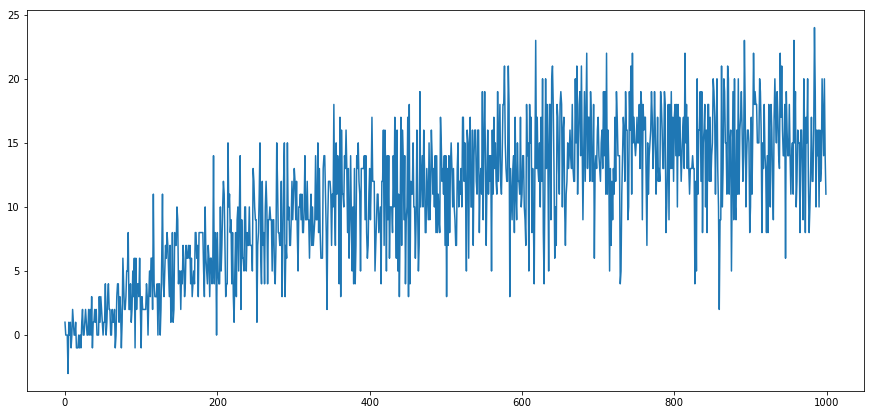

In [73]:
ax = plot_scores(scores)
plt.show()

In [75]:
ax.figure.savefig('agent-trend-final.png')

In [70]:
print('Saving model')
torch.save(agent.qnetwork_local.state_dict(), 'banana_final_model.bin')

Saving model


### 8. Play the agent

The code below optionally runs the trained agent for `N` steps. We can see it collecting yellow bananas!

In [76]:
env_info = env.reset(train_mode=False)[brain_name] 
state = env_info.vector_observations[0]            
score = 0 

# update here for how long to keep the agent wandering.
N = 200


i = 0
while i < N:
    action = agent.act(state, 0.01)
    env_info = env.step(action)[brain_name]        
    next_state = env_info.vector_observations[0]   
    reward = env_info.rewards[0]                   
    done = env_info.local_done[0]                  
    score += reward                                
    state = next_state                             

    if done:                                       
        break
    
    i += 1
    
print("Score: {}".format(score))

Score: 13.0
